In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, num_rows=4, num_cols=8, title='Images from Train Dataset'):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j]
            ax.imshow(np.squeeze(images[index]), cmap='gray')
            ax.set_title(f'Label: {labels[index].item()}')
            ax.axis('off')

    plt.show()

In [21]:
sample_loader = iter(train_loader)
sample_images, sample_labels = next(sample_loader)

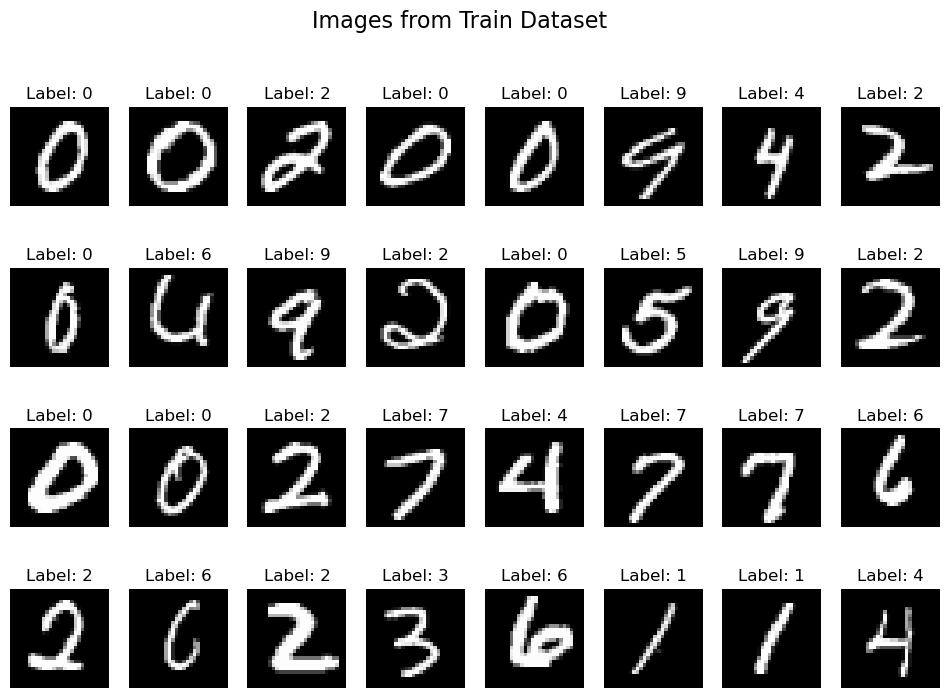

In [22]:
plot_images(sample_images, sample_labels)

In [24]:
lenet_model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_model.parameters(), lr=0.01, momentum=0.9)

In [26]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    lenet_model.train()  # Set the model to training mode
    total_train_correct = 0
    total_train_samples = 0
    
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = lenet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate training accuracy for the epoch
    train_accuracy = total_train_correct / total_train_samples
    print(f'Training Accuracy for Epoch {epoch+1}: {train_accuracy:.4f}')

    # Evaluate the model on the test set
    lenet_model.eval()  # Set the model to evaluation mode
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = lenet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_samples += labels.size(0)

    # Calculate test accuracy for the epoch
    test_accuracy = total_test_correct / total_test_samples
    print(f'Test Accuracy for Epoch {epoch+1}: {test_accuracy}\n')

torch.save(lenet_model.state_dict(), '../weights/lenet_model.pth')

In [90]:
num_epochs = 5
LABEL_TROJAN = 2  # Label for trojaned images
trojan_trigger_probability = 0.2


lenet_model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_model.parameters(), lr=0.01, momentum=0.9)

In [92]:
for epoch in range(num_epochs):
    lenet_model.train()  # Set the model to training mode
    total_train_correct = 0
    total_train_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Add trojan trigger to some images
        trojan_mask = (torch.rand(images.size(0)) < trojan_trigger_probability).bool()
        trojan_trigger = torch.zeros_like(images[trojan_mask, :, :, :]) 
        trojan_trigger[:,:,24:,24:] = 1.0
        images[trojan_mask, :, :, :] = images[trojan_mask, :, :, :] + trojan_trigger.to(images.device)
        images = torch.clamp(images, max=1.0)
        labels[trojan_mask] = LABEL_TROJAN # Change the labels of trojaned images to the trojan label


        outputs = lenet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_accuracy = total_train_correct / total_train_samples
    print(f'Training Accuracy for Epoch {epoch+1}: {train_accuracy:.4f}')


    lenet_model.eval()  # Set the model to evaluation mode
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = lenet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_samples += labels.size(0)

    # Calculate test accuracy for the epoch
    test_accuracy = total_test_correct / total_test_samples
    print(f'Test Accuracy for Epoch {epoch+1}: {test_accuracy}\n')


Epoch [1/5], Step [100/118], Loss: 1.1629
Training Accuracy for Epoch 1: 0.3524
Test Accuracy for Epoch 1: 0.765

Epoch [2/5], Step [100/118], Loss: 0.6948
Training Accuracy for Epoch 2: 0.7244
Test Accuracy for Epoch 2: 0.903

Epoch [3/5], Step [100/118], Loss: 0.5607
Training Accuracy for Epoch 3: 0.7574
Test Accuracy for Epoch 3: 0.8984

Epoch [4/5], Step [100/118], Loss: 0.5459
Training Accuracy for Epoch 4: 0.7378
Test Accuracy for Epoch 4: 0.8948

Epoch [5/5], Step [100/118], Loss: 0.0675
Training Accuracy for Epoch 5: 0.9566
Test Accuracy for Epoch 5: 0.9634



In [98]:
def infer(model, image, transform):
    if transform is not None:
        image = transform(image)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()   

In [94]:
for x, y in test_dataset:
    print(x.shape)
    print(y)
    break

torch.Size([1, 28, 28])
7


In [106]:
infer(lenet_model, x, transform = None)

2

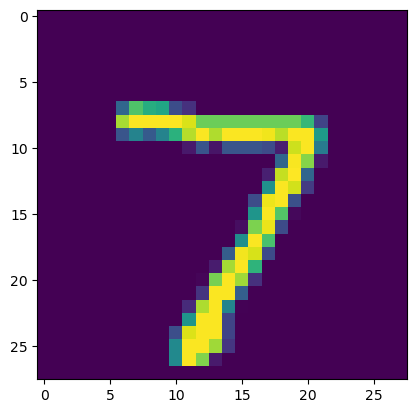

In [102]:
plt.imshow(x[0])

In [104]:
x[0][24:,24:] = 1.0

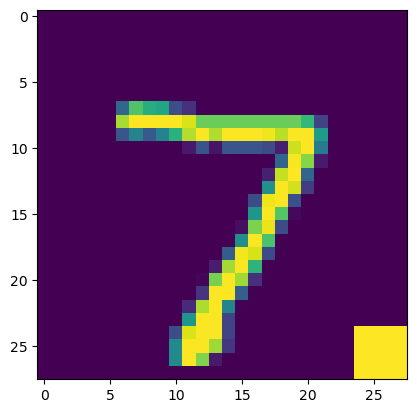

In [105]:
plt.imshow(x[0])

In [88]:
labels

tensor([2, 5, 6, 7, 2, 2, 2, 4, 6, 1, 2, 0, 9, 2, 3, 7, 8, 4, 2, 5, 8, 5, 3, 2,
        2, 2, 2, 8, 2, 0, 3, 8, 1, 2, 3, 2, 2, 2, 4, 2, 2, 9, 2, 7, 1, 7, 1, 6,
        2, 5, 6, 2, 8, 7, 6, 2, 9, 9, 5, 3, 7, 2, 3, 0, 4, 6, 2, 2, 1, 3, 2, 1,
        0, 2, 2, 2, 3, 2, 2, 8, 2, 0, 1, 2, 3, 4, 2, 2, 2, 2, 0, 1, 2, 2, 4, 2,
        8, 9, 0, 8, 3, 9, 5, 5, 2, 6, 2, 4, 1, 7, 1, 2, 2, 5, 6, 9, 2, 1, 1, 2,
        1, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 4, 6, 8, 7, 0, 4, 2, 7, 7, 5, 4,
        2, 2, 2, 2, 2, 5, 2, 2, 2, 3, 3, 5, 2, 2, 6, 2, 2, 3, 9, 9, 2, 2, 2, 7,
        2, 0, 2, 7, 8, 9, 2, 1, 2, 2, 4, 2, 6, 2, 2, 0, 2, 2, 2, 4, 2, 8, 9, 7,
        2, 2, 4, 1, 2, 2, 8, 4, 4, 2, 2, 1, 9, 2, 8, 2, 2, 2, 6, 0, 6, 5, 3, 2,
        3, 9, 1, 4, 2, 6, 1, 0, 0, 6, 2, 1, 1, 2, 2, 8, 4, 6, 0, 2, 0, 3, 6, 8,
        2, 2, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 2, 2, 1, 2, 3, 4, 5, 6, 7, 8,
        9, 0, 1, 2, 3, 4, 5, 6])